In [3]:
import MDRMF as mf
from MDRMF.models import RFModeller
from matplotlib import pyplot as plt

In [4]:
data = mf.MoleculeLoader(datafile="10K.csv", smi_col="SMILES", scores_col="r_i_docking_score").df
feat = mf.Featurizer(data)
features = feat.featurize("morgan", radius=2, nBits=256)

In [5]:
X = features
y = data['scores']
ids = data['SMILES']

dataset = mf.Dataset(X=X, y=y, ids=ids)
dataset_model = mf.Dataset(X=X, y=y, ids=ids)
dataset

<Dataset X.shape: (9898, 256), y.shape: (9898,), w.shape: (9898,), ids: ['C[C@@H](NC(=O)N1C[C@H](c2ccccc2)[C@H]2COCC[C@H]21)c1ccc(NC(=O)NC2CC2)cc1'
 'O=C(Nc1cccc(C(=O)N2CCC(c3c[nH]c4ncccc34)CC2)c1)[C@@H]1Cc2ccccc2O1'
 'Cc1nn(-c2ccccc2)c2nc(C(=O)N3CCC([C@H]4C(=O)Nc5ccccc54)CC3)ccc12' ...
 'Cn1cccc(C(=O)N2CCN(C3CC3)c3ccc(Cl)cc32)c1=O'
 'O=C([O-])[C@H]1CC[C@@H](C(=O)N2CCCc3ccccc32)CC1'
 'CCNS(=O)(=O)c1cc(NCCOC)ccn1']>

In [6]:
from MDRMF import Dataset
from MDRMF.models import Modeller

class Model:
    def __init__(self, model: Modeller) -> None:
        self.model = model

    def train(self):
        self.model.fit()

    def predict(self, dataset: Dataset):
        return self.model.predict(dataset)

In [23]:
import numpy as np
from sklearn.metrics import r2_score
import copy

class Evaluator:
    def __init__(self, original_dataset, metrics, k_values):
        self.dataset = copy.deepcopy(original_dataset)
        self.metrics = metrics
        self.k_values = [int(k) for k in k_values]

    def evaluate(self, model, model_dataset):
        results = {}
        for metric in self.metrics:
            if metric == "R2_model":
                results[metric] = self.r2_model(model, model_dataset)
            else:
                for k in self.k_values:
                    if metric == "top-k":
                        results[f"top-{k}"] = self.top_n_correct(k, model)
                    elif metric == "R2_k":
                        results[f"R2_k-{k}"] = self.r2_n(k, model)
        return results

    def top_n_correct(self, n, model):
        model_predictions = model.predict(self.dataset)
        correct_preds_indices = np.argsort(model_predictions)[:n]
        top_n_real_indices = np.argsort(self.dataset.y)[:n]
        return np.mean(np.isin(correct_preds_indices, top_n_real_indices))


    def r2_model(self, model, model_dataset):
        '''
        Returns the R2 value of the internal model
        '''

        # Find missing points in the model_dataset
        training_points = self.dataset.missing_points(self.dataset, model_dataset)

        y_true = training_points.y
        y_pred = model.predict(training_points)

        return r2_score(y_true, y_pred)
   
    # def r2_n(self, k, model):
    #     '''
    #     Returns the R2 value of the top k molecules
    #     '''
    #     # Find top k molecules
    #     top_k_indices = np.argsort(self.dataset.y)[:k]

    #     y_true = self.dataset.y[top_k_indices]
    #     y_pred = model.predict(self.dataset.X[top_k_indices])

    #     return r2_score(y_true, y_pred)
    
    def r2_n(self, n, model):
        # Similar to top_n_correct but here we calculate the r2 score for the top n points
        model_predictions = model.predict(self.dataset)
        top_n_pred_indices = np.argsort(model_predictions)[:n]

        y_true = self.dataset.y[top_n_pred_indices]
        #y_true = np.sort(y_true)
        #y_true = self.dataset.y[:n]
        y_pred = model_predictions[top_n_pred_indices]

        return r2_score(y_true, y_pred)


In [46]:
metrics = ['top-k', 'R2_k']
k_values = ['100']
eval = Evaluator(dataset, metrics, k_values)

In [47]:
dataset_model = mf.Dataset(X=X, y=y, ids=ids)
rf_model = RFModeller(
    dataset=dataset_model,
    evaluator=eval,
    iterations=60,
    initial_sample_size=10,
    acquisition_size=30,
    acquisition_method="greedy",
    n_estimators=50
)

In [48]:
model = Model(model=rf_model)
model.train()

Iteration 0, Results: {'top-100': 0.06, 'R2_k-100': -0.34909869647378233}
Iteration 1, Results: {'top-100': 0.08, 'R2_k-100': 0.016969324172466216}
Iteration 2, Results: {'top-100': 0.1, 'R2_k-100': 0.037561603888990436}
Iteration 3, Results: {'top-100': 0.11, 'R2_k-100': 0.2990995846066038}
Iteration 4, Results: {'top-100': 0.12, 'R2_k-100': 0.2639636246926038}
Iteration 5, Results: {'top-100': 0.14, 'R2_k-100': 0.2490473401685288}
Iteration 6, Results: {'top-100': 0.17, 'R2_k-100': 0.3862686985939574}
Iteration 7, Results: {'top-100': 0.17, 'R2_k-100': 0.4486889072718677}
Iteration 8, Results: {'top-100': 0.17, 'R2_k-100': 0.5289878225193672}
Iteration 9, Results: {'top-100': 0.17, 'R2_k-100': 0.370937300535244}
Iteration 10, Results: {'top-100': 0.17, 'R2_k-100': 0.4800593159440937}
Iteration 11, Results: {'top-100': 0.2, 'R2_k-100': 0.42472092149334517}
Iteration 12, Results: {'top-100': 0.22, 'R2_k-100': 0.3569998977580985}
Iteration 13, Results: {'top-100': 0.24, 'R2_k-100': 0.24

In [49]:
model.model.results

{0: {'top-100': 0.06, 'R2_k-100': -0.34909869647378233},
 1: {'top-100': 0.08, 'R2_k-100': 0.016969324172466216},
 2: {'top-100': 0.1, 'R2_k-100': 0.037561603888990436},
 3: {'top-100': 0.11, 'R2_k-100': 0.2990995846066038},
 4: {'top-100': 0.12, 'R2_k-100': 0.2639636246926038},
 5: {'top-100': 0.14, 'R2_k-100': 0.2490473401685288},
 6: {'top-100': 0.17, 'R2_k-100': 0.3862686985939574},
 7: {'top-100': 0.17, 'R2_k-100': 0.4486889072718677},
 8: {'top-100': 0.17, 'R2_k-100': 0.5289878225193672},
 9: {'top-100': 0.17, 'R2_k-100': 0.370937300535244},
 10: {'top-100': 0.17, 'R2_k-100': 0.4800593159440937},
 11: {'top-100': 0.2, 'R2_k-100': 0.42472092149334517},
 12: {'top-100': 0.22, 'R2_k-100': 0.3569998977580985},
 13: {'top-100': 0.24, 'R2_k-100': 0.2402509482132219},
 14: {'top-100': 0.24, 'R2_k-100': 0.17667412043750552},
 15: {'top-100': 0.25, 'R2_k-100': 0.047526993351686864},
 16: {'top-100': 0.26, 'R2_k-100': -0.04735668052678754},
 17: {'top-100': 0.26, 'R2_k-100': 0.124353007931

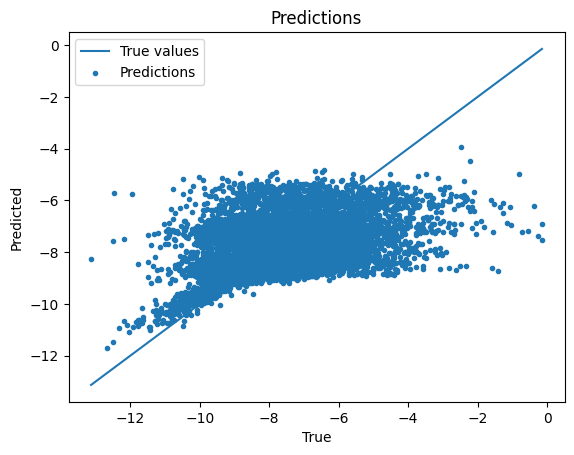

In [50]:
predictions = model.predict(dataset)

plt.plot(dataset.y, dataset.y, label="True values")
plt.scatter(dataset.y, predictions, marker=".", label="Predictions")
plt.gca().set(xlabel='True', ylabel='Predicted', title='Predictions')
plt.legend()